In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
def reReadData():
  df=pd.read_csv('gdrive/My Drive/Data_Version_4.csv',header=0, index_col=0, 
                infer_datetime_format=True, parse_dates=['Date'])
  df['log_ret'] = np.log(df['Russell3000_Adj_Close']) - np.log(df['Russell3000_Adj_Close'].shift(1))
  #df = df.dropna()
  #df = df[train_start:test_end]
  #df_train, df_test = df[train_start:train_end],df[train_end:test_end]
  return df


def plotProb_train(model):
  bear_regime = 0 if model.params['const[0]']<model.params['const[1]'] else 1

  fig, axes = plt.subplots(2, figsize=(15, 15))

  ax = axes[0]
  ax.plot(df_train.index, df_train['Russell_Close'])
  ax.set(title='Russell_Close')
  
  ax = axes[1]
  ax.plot(df_train.index, model.filtered_marginal_probabilities[bear_regime])
  ax.set(title='Filtered probability of bear_regime')

  plt.show()


def plotProb_test(model):
  bear_regime = 0 if model.params['const[0]']<model.params['const[1]'] else 1

  fig, axes = plt.subplots(2, figsize=(15, 15))

  ax = axes[0]
  ax.plot(df_test.index, df_test['Russell_Close'])
  ax.set(title='Russell_Close')
  
  ax = axes[1]
  ax.plot(df_test.index, model.filtered_marginal_probabilities[bear_regime])
  ax.set(title='Filtered probability of bear_regime')

  plt.show()


def labeling(model,threshold1, threshold2):
  bear_regime = 0 if model.params['const[0]'] < model.params['const[1]'] else 1

  label_filtered = []
  
  for i in model.filtered_marginal_probabilities[bear_regime].values:
    if i >= threshold1:
      app = -1
    elif i >= threshold2:
      app = 0
    else:
      app = 1
    label_filtered.append(app)

  label_filtered= np.array(label_filtered)
  
  return label_filtered


def duration(label):

  duration_bull = []
  duration_static = []
  duration_bear = []

  count,prev,trade = 1,1,0

  for i in label:
    if i == prev:
      count+=1
    else:
      trade+=1
      if prev == 1:
        duration_bull.append(count)
        count = 1
      elif prev == 0:
        duration_static.append(count)
        count = 1
      else:
        duration_bear.append(count)
        count = 1
    prev = i
    
  if prev == 1:
    duration_bull.append(count)
  elif prev == 0:
    duration_static.append(count)
  else:
    duration_bear.append(count)

  duration_bull = pd.DataFrame(duration_bull)
  duration_static = pd.DataFrame(duration_static)
  duration_bear = pd.DataFrame(duration_bear)

  return duration_bull, duration_static, duration_bear,trade


def label_train_logret(label):
  return (df_train['log_ret'] * label).sum()

def label_test_logret(label):
  return (df_test['log_ret'] * label).sum()



def Search_train(model, duration_static, duration_bear):
  threshold1, threshold2, record =0,0,0
  for i in range(1,101):
    for j in range(i):
      label_filtered = labeling(model,i/100, j/100)
      if ( (duration(label_filtered))[1].mean().values >= duration_static ):
        if ( (duration(label_filtered))[2].mean().values >= duration_bear ) :
          if ( (df_train['log_ret'] * label_filtered).sum() >= record ):
            threshold1, threshold2, record = i,j,(df_train['log_ret'] * label_filtered).sum()
  return threshold1/100, threshold2/100

## Set parameters

In [4]:
duration_static, duration_bear = 2, 4
#train_start = '2010-01-01'
#train_end = '2017-12-31'
#test_end = '2020-12-31'

In [5]:
train_start = '2000-01-01'
train_end = '2017-12-31'
test_end = '2022-01-25'

## Read Data

In [6]:
#df,df_train,df_test = reReadData()
df = reReadData()
print(df)

             PX_LAST     PX_VOLUME  ...  Russell3000_Volume   log_ret
Date                                ...                              
1990-01-02    585.41           NaN  ...                 0.0       NaN
1990-01-03    585.05           NaN  ...                 0.0 -0.000999
1990-01-04    580.97           NaN  ...                 0.0 -0.006316
1990-01-05    575.74           NaN  ...                 0.0 -0.010058
1990-01-08    577.78           NaN  ...                 0.0  0.003448
...              ...           ...  ...                 ...       ...
2022-01-19  14547.22  1.322548e+09  ...                 0.0 -0.010180
2022-01-20  14378.11  1.355285e+09  ...                 0.0 -0.011763
2022-01-21  14099.17  1.917342e+09  ...                 0.0 -0.019599
2022-01-24  14173.27  2.178968e+09  ...                 0.0  0.000000
2022-01-25  13982.41  1.611222e+09  ...                 0.0  0.000000

[8090 rows x 45 columns]


## Construct MA and EMA columns

In [7]:
for k in [5,10,15]:
  name = 'log_ret_MA'+str(k)
  df[name] = df['log_ret'].rolling(k).mean()
  name1 = 'log_ret_EWMA'+str(k)
  df[name1] = df['log_ret'].ewm(span=k).mean()  
df

,PX_LAST,PX_VOLUME,T1M,T3M,T6M,T1Y,T3Y,T5Y,T10Y,T30Y,T10Y3M,T10Y2Y,LIBOR_3M,TEDRATE,InterestRate,WTI_Futures_Price,WTI_Futures_Return,WTI_Spot_Price,WTI_Spot_Change,Commdity_channel_index_13,Williams_pct_14,RSI_14,Parabolic_0.02_0.2_0.02,DMI_14_ADX,Fear_Greedy_Index,CPI_monthly percent change,CPI_Release,Unemployment_rate,Unemployment_Release,change_in_total_nonfarm_thousand,Nonfarm_Release,VIX_Close,GDP_QOQ_change,GDP_Release,SPY_Adj_Close,SPY_Volume,SP_Adj_Close,SP_Volume,Mkt-RF,SMB,HML,RF,Russell3000_Adj_Close,Russell3000_Volume,log_ret,log_ret_MA5,log_ret_EWMA5,log_ret_MA10,log_ret_EWMA10,log_ret_MA15,log_ret_EWMA15
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1990-01-02,585.41,NaN,NaN,7.83,7.50,7.81,7.90,7.87,7.94,8.00,0.11,0.07,8.38000,0.80,8.54,22.89,0.0490,22.89,0.0490,158.6294,-0.8405,69.0585,190.157,17.2194,2.3009,0.3,0.0,5.4,0.0,276.0,0.0,17.240000,0.8,0.0,NaN,NaN,359.69,1.620700e+08,1.44,-0.68,-0.07,0.026,200.309998,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,585.05,NaN,NaN,7.89,7.53,7.85,7.96,7.92,7.99,8.04,0.10,0.05,8.38000,0.75,8.37,23.68,0.0345,23.68,0.0345,166.5505,-6.7745,68.4778,190.767,18.4101,3.0652,0.3,0.0,5.4,0.0,276.0,0.0,18.190001,0.8,0.0,NaN,NaN,358.76,1.923300e+08,-0.06,0.74,-0.26,0.026,200.110001,0.0,-0.000999,NaN,-0.000999,NaN,-0.000999,NaN,-0.000999
1990-01-04,580.97,NaN,NaN,7.84,7.50,7.82,7.93,7.91,7.98,8.04,0.14,0.06,8.38000,0.79,8.29,23.41,-0.0114,23.41,-0.0114,104.2355,-19.9820,61.8875,191.575,18.1196,1.8271,0.3,0.0,5.4,0.0,276.0,0.0,19.219999,0.8,0.0,NaN,NaN,355.67,1.770000e+08,-0.71,0.42,-0.22,0.026,198.850006,0.0,-0.006316,NaN,-0.004189,NaN,-0.003924,NaN,-0.003835
1990-01-05,575.74,NaN,NaN,7.79,7.46,7.79,7.94,7.92,7.99,8.06,0.20,0.09,8.38000,0.84,8.20,23.08,-0.0141,23.08,-0.0141,56.8323,-36.1185,54.9317,192.319,17.4400,-0.2747,0.3,0.0,5.4,0.0,84.0,1.0,20.110001,0.8,0.0,NaN,NaN,352.20,1.585300e+08,-0.85,0.77,-0.21,0.026,196.860001,0.0,-0.010058,NaN,-0.006969,NaN,-0.006390,NaN,-0.006192
1990-01-08,577.78,NaN,NaN,7.79,7.49,7.81,7.95,7.92,8.02,8.09,0.23,0.12,8.38000,0.84,8.27,21.62,-0.0633,21.62,-0.0633,43.9596,-30.0539,56.8927,193.003,16.6146,-0.5619,0.3,0.0,5.4,0.0,84.0,0.0,20.260000,0.8,0.0,NaN,NaN,353.79,1.401100e+08,0.30,-0.41,-0.26,0.026,197.539993,0.0,0.003448,NaN,-0.002642,NaN,-0.003148,NaN,-0.003280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-19,14547.22,1.322548e+09,0.05,0.17,0.36,0.57,1.33,1.62,1.83,2.14,1.66,0.79,0.25514,0.09,0.08,86.96,0.0179,85.58,-0.0135,-167.3056,-99.3827,32.9727,2780.178,21.6253,-124.8524,0.5,0.0,3.9,0.0,199.0,0.0,23.850000,2.3,0.0,451.750000,109357600.0,4532.76,3.387370e+09,-0.31,0.06,0.53,0.000,2633.860107,0.0,-0.010180,-0.008528,-0.008960,-0.006132,-0.006185,-0.004039,-0.004643
2022-01-20,14378.11,1.355285e+09,0.05,0.17,0.36,0.60,1.34,1.62,1.83,2.14,1.66,0.75,0.25886,0.08,0.08,86.90,-0.0007,84.67,-0.0106,-163.7336,-98.8126,29.7787,2768.382,23.3995,-171.7405,0.5,0.0,3.9,0.0,199.0,0.0,25.590000,2.3,0.0,446.750000,122379700.0,4482.73,3.473060e+09,-0.31,0.06,0.53,0.000,2603.060059,0.0,-0.011763,-0.011175,-0.009894,-0.005103,-0.007199,-0.004907,-0.005533
2022-01-21,14099.17,1.917342e+09,0.05,0.17,0.35,0.58,1.28,1.54,1.75,2.07,1.58,0.74,0.25771,0.09,0.08,85.14,-0.0203,85.43,0.0090,-191.9934,-99.7294,25.4267,2751.593,25.6026,-213.5388,0.5,0.0,3.9,0.0,199.0,0.0,28.850000,2.3,0.0,437.980011,202271200.0,4397.94,3.945810e+09,-0.31,0.06,0.53,0.000,2552.540039,0.0,-0.019599,-0.012187,-0.013129,-0.007058,-0.009453,-0.006071,-0.007291


In [8]:
df = df.iloc[15: , :]

##Split training and testing sets

In [9]:
#df = df.dropna()
df = df[train_start:test_end]
df_train, df_test = df[train_start:train_end],df[train_end:test_end]
print(df,df_train,df_test)

             PX_LAST     PX_VOLUME  ...  log_ret_MA15  log_ret_EWMA15
Date                                ...                              
2000-01-03   2909.89  1.748611e+09  ...      0.001836        0.001467
2000-01-04   2795.36  1.805332e+09  ...     -0.000677       -0.003646
2000-01-05   2802.51  2.100967e+09  ...      0.000168       -0.002977
2000-01-06   2784.07  1.972651e+09  ...     -0.000207       -0.002664
2000-01-07   2878.11  2.151953e+09  ...      0.001289        0.001013
...              ...           ...  ...           ...             ...
2022-01-19  14547.22  1.322548e+09  ...     -0.004039       -0.004643
2022-01-20  14378.11  1.355285e+09  ...     -0.004907       -0.005533
2022-01-21  14099.17  1.917342e+09  ...     -0.006071       -0.007291
2022-01-24  14173.27  2.178968e+09  ...     -0.005886       -0.006380
2022-01-25  13982.41  1.611222e+09  ...     -0.006286       -0.005582

[5558 rows x 51 columns]             PX_LAST     PX_VOLUME  ...  log_ret_MA15  log_ret_EW

In [10]:
df_output = pd.DataFrame(data = df['log_ret'],index = df.index)
df_output

,log_ret
Date,
2000-01-03,-0.009003
2000-01-04,-0.039434
2000-01-05,0.001705
2000-01-06,-0.000476
2000-01-07,0.026756
...,...
2022-01-19,-0.010180
2022-01-20,-0.011763
2022-01-21,-0.019599


## Basic HHM

In [11]:
hmm1 = sm.tsa.MarkovRegression(endog=df_train['log_ret'], k_regimes=2,trend='c',switching_variance=True)
hmm1_results = hmm1.fit(search_reps = 100)
print(hmm1_results.summary())

t1,t2 = Search_train(hmm1_results, duration_static, duration_bear)
label_filtered_result = labeling(hmm1_results,t1,t2)
print((duration(label_filtered_result))[0].mean())
print((duration(label_filtered_result))[1].mean())
print((duration(label_filtered_result))[2].mean())
print((duration(label_filtered_result))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered_result))
print(np.histogram(label_filtered_result))

hmm1_test = sm.tsa.MarkovRegression(endog=df_test['log_ret'], k_regimes=2,trend='c',switching_variance=True)
hmm1_test_results = hmm1_test.fit(start_params = hmm1_results.params, maxiter = 0)

label_filtered_test = labeling(hmm1_test_results,t1,t2)
print((duration(label_filtered_test))[0].mean())
print((duration(label_filtered_test))[1].mean())
print((duration(label_filtered_test))[2].mean())
print((duration(label_filtered_test))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered_test))
print(np.histogram(label_filtered_test))

name3 = 'hmm1'
label_concat = np.concatenate((label_filtered_result,label_filtered_test),axis=None)
df_output[name3] = label_concat

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:                log_ret   No. Observations:                 4534
Model:               MarkovRegression   Log Likelihood               14373.200
Date:                Sun, 13 Feb 2022   AIC                         -28734.399
Time:                        03:37:14   BIC                         -28695.883
Sample:                             0   HQIC                        -28720.833
                               - 4534                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.001     -1.922      0.055      -0.002    2.07e-05
sigma2         0.0004   1.87e-05     20.594      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [12]:
for k in [5,10,15]:

  name = 'log_ret_MA'+str(k)
  hmm1 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c',switching_variance=True)
  hmm1_results = hmm1.fit(search_reps = 100)
  print(hmm1_results.summary())

  t1,t2 = Search_train(hmm1_results, duration_static, duration_bear)
  label_filtered_result = labeling(hmm1_results,t1,t2)
  print((duration(label_filtered_result))[0].mean())
  print((duration(label_filtered_result))[1].mean())
  print((duration(label_filtered_result))[2].mean())
  print((duration(label_filtered_result))[3])
  print(df_train['log_ret'].sum(), label_train_logret(label_filtered_result))
  print(np.histogram(label_filtered_result))

  hmm1_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c',switching_variance=True)
  hmm1_test_results = hmm1_test.fit(start_params = hmm1_results.params, maxiter = 0)

  label_filtered_test = labeling(hmm1_test_results,t1,t2)
  print((duration(label_filtered_test))[0].mean())
  print((duration(label_filtered_test))[1].mean())
  print((duration(label_filtered_test))[2].mean())
  print((duration(label_filtered_test))[3])
  print(df_test['log_ret'].sum(), label_test_logret(label_filtered_test))
  print(np.histogram(label_filtered_test))


  name3 = 'hmm1_MA'+str(k)
  label_concat = np.concatenate((label_filtered_result,label_filtered_test),axis=None)
  df_output[name3] = label_concat
  print('===================================================')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:            log_ret_MA5   No. Observations:                 4534
Model:               MarkovRegression   Log Likelihood               18557.422
Date:                Sun, 13 Feb 2022   AIC                         -37102.845
Time:                        03:37:55   BIC                         -37064.329
Sample:                             0   HQIC                        -37089.278
                               - 4534                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.000     -7.188      0.000      -0.002      -0.001
sigma2      5.291e-05   2.22e-06     23.859      0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0    10.836842
dtype: float64
0    3.640476
dtype: float64
0    4.012712
dtype: float64
845
0.6907177051960405 3.651769049833292
(array([ 947,    0,    0,    0,    0, 1529,    0,    0,    0, 2058]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))
0    11.886364
dtype: float64
0    2.910891
dtype: float64
0    3.466667
dtype: float64
204
0.47791246821157074 1.0800284216117202
(array([208,   0,   0,   0,   0, 294,   0,   0,   0, 522]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:           log_ret_MA10   No. Observations:                 4534
Model:               MarkovRegression   Log Likelihood               20612.290
Date:                Sun, 13 Feb 2022   AIC                         -41212.581
Time:                        03:38:28   BIC                         -41174.065
Sample:                             0   HQIC                        -41199.014
                               - 4534                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.000    -10.126      0.000      -0.002      -0.001
sigma2      2.314e-05   1.04e-06     22.275      0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0    20.852564
dtype: float64
0    2.021053
dtype: float64
0    4.4125
dtype: float64
600
0.6907177051960405 3.814356656887707
(array([ 706,    0,    0,    0,    0,  576,    0,    0,    0, 3252]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))
0    23.96875
dtype: float64
0    1.833333
dtype: float64
0    4.818182
dtype: float64
118
0.47791246821157074 1.2966273919998095
(array([159,   0,   0,   0,   0,  99,   0,   0,   0, 766]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:           log_ret_MA15   No. Observations:                 4534
Model:               MarkovRegression   Log Likelihood               21786.608
Date:                Sun, 13 Feb 2022   AIC                         -43561.215
Time:                        03:38:59   BIC                         -43522.699
Sample:                             0   HQIC                        -43547.649
                               - 4534                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.000    -14.032      0.000      -0.002      -0.001
sigma2      1.284e-05   5.56e-07     23.104      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [13]:
for k in [5,10,15]:

  name = 'log_ret_EWMA'+str(k)
  hmm1 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c',switching_variance=True)
  hmm1_results = hmm1.fit(search_reps = 100)
  print(hmm1_results.summary())

  t1,t2 = Search_train(hmm1_results, duration_static, duration_bear)
  label_filtered_result = labeling(hmm1_results,t1,t2)
  print((duration(label_filtered_result))[0].mean())
  print((duration(label_filtered_result))[1].mean())
  print((duration(label_filtered_result))[2].mean())
  print((duration(label_filtered_result))[3])
  print(df_train['log_ret'].sum(), label_train_logret(label_filtered_result))
  print(np.histogram(label_filtered_result))

  hmm1_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c',switching_variance=True)
  hmm1_test_results = hmm1_test.fit(start_params = hmm1_results.params, maxiter = 0)

  label_filtered_test = labeling(hmm1_test_results,t1,t2)
  print((duration(label_filtered_test))[0].mean())
  print((duration(label_filtered_test))[1].mean())
  print((duration(label_filtered_test))[2].mean())
  print((duration(label_filtered_test))[3])
  print(df_test['log_ret'].sum(), label_test_logret(label_filtered_test))
  print(np.histogram(label_filtered_test))

  name3 = 'hmm1_EWMA'+str(k)
  label_concat = np.concatenate((label_filtered_result,label_filtered_test),axis=None)
  df_output[name3] = label_concat
  print('===================================================')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:          log_ret_EWMA5   No. Observations:                 4534
Model:               MarkovRegression   Log Likelihood               18452.828
Date:                Sun, 13 Feb 2022   AIC                         -36893.655
Time:                        03:39:29   BIC                         -36855.139
Sample:                             0   HQIC                        -36880.089
                               - 4534                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012    7.4e-05     16.063      0.000       0.001       0.001
sigma2       6.58e-06   3.34e-07     19.720      0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0    14.316667
dtype: float64
0    2.314433
dtype: float64
0    4.156863
dtype: float64
822
0.6907177051960405 5.124114691542813
(array([1060,    0,    0,    0,    0,  898,    0,    0,    0, 2576]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))
0    13.77551
dtype: float64
0    1.862069
dtype: float64
0    3.186441
dtype: float64
194
0.47791246821157074 2.0614589939595014
(array([188,   0,   0,   0,   0, 162,   0,   0,   0, 674]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:         log_ret_EWMA10   No. Observations:                 4534
Model:               MarkovRegression   Log Likelihood               20432.461
Date:                Sun, 13 Feb 2022   AIC                         -40852.921
Time:                        03:40:03   BIC                         -40814.405
Sample:                             0   HQIC                        -40839.355
                               - 4534                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.000    -12.643      0.000      -0.002      -0.002
sigma2      2.219e-05   9.95e-07     22.291      0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0    13.685279
dtype: float64
0    2.594805
dtype: float64
0    4.057971
dtype: float64
788
0.6907177051960405 7.111245622843083
(array([ 840,    0,    0,    0,    0,  999,    0,    0,    0, 2695]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))
0    17.972973
dtype: float64
0    2.038961
dtype: float64
0    3.980392
dtype: float64
164
0.47791246821157074 1.93948604655061
(array([203,   0,   0,   0,   0, 157,   0,   0,   0, 664]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:         log_ret_EWMA15   No. Observations:                 4534
Model:               MarkovRegression   Log Likelihood               21665.557
Date:                Sun, 13 Feb 2022   AIC                         -43319.113
Time:                        03:40:35   BIC                         -43280.597
Sample:                             0   HQIC                        -43305.547
                               - 4534                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013   5.99e-05     20.863      0.000       0.001       0.001
sigma2      1.701e-06    1.5e-07     11.314      0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0    20.43871
dtype: float64
0    2.013333
dtype: float64
0    4.286517
dtype: float64
632
0.6907177051960405 6.9157015717332975
(array([ 763,    0,    0,    0,    0,  604,    0,    0,    0, 3167]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))
0    21.970588
dtype: float64
0    1.693548
dtype: float64
0    4.435897
dtype: float64
134
0.47791246821157074 1.97228575898884
(array([173,   0,   0,   0,   0, 105,   0,   0,   0, 746]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [14]:
df_output

,log_ret,hmm1,hmm1_MA5,hmm1_MA10,hmm1_MA15,hmm1_EWMA5,hmm1_EWMA10,hmm1_EWMA15
Date,,,,,,,,
2000-01-03,-0.009003,1,0,1,1,1,1,1
2000-01-04,-0.039434,-1,-1,1,1,-1,-1,-1
2000-01-05,0.001705,-1,-1,1,1,-1,-1,-1
2000-01-06,-0.000476,-1,-1,1,1,-1,-1,-1
2000-01-07,0.026756,-1,-1,1,1,-1,0,0
...,...,...,...,...,...,...,...,...
2022-01-19,-0.010180,0,-1,-1,-1,-1,-1,-1
2022-01-20,-0.011763,0,-1,-1,-1,-1,-1,-1
2022-01-21,-0.019599,-1,-1,-1,-1,-1,-1,-1


In [15]:
model = 'hmm1'

duration_bear = duration_static = duration_bull = 0
duration_bear_list = []
duration_static_list = [] 
duration_bull_list = []

for i in range(len(df_output[model])):
  if df_output[model].iloc[i] == -1:
    duration_bull = 0
    duration_static = 0
    duration_bear+=1 
  elif df_output[model].iloc[i] == 0:
    duration_bull = 0
    duration_bear = 0
    duration_static+=1
  else:
    duration_bear = 0
    duration_static = 0
    duration_bull+=1

  duration_bear_list.append(duration_bear)
  duration_static_list.append(duration_static)
  duration_bull_list.append(duration_bull)

duration_bear_array = np.array(duration_bear_list)
duration_static_array = np.array(duration_static_list)
duration_bull_array = np.array(duration_bull_list)

name1, name2, name3 = model+'_duration_bear', model+'_duration_static', model+'_duration_bull'
df_output[name1],df_output[name2],df_output[name3] = duration_bear_array,duration_static_array,duration_bull_array


In [16]:
df_output[['hmm1',name1,name2,name3]].tail(30)

,hmm1,hmm1_duration_bear,hmm1_duration_static,hmm1_duration_bull
Date,,,,
2021-12-13,0,0,4,0
2021-12-14,1,0,0,1
2021-12-15,0,0,1,0
2021-12-16,0,0,2,0
2021-12-17,0,0,3,0
2021-12-20,0,0,4,0
2021-12-21,-1,1,0,0
2021-12-22,0,0,1,0
2021-12-23,0,0,2,0


In [17]:
for model in ['hmm1_MA5',	'hmm1_MA10',	'hmm1_MA15',	'hmm1_EWMA5',	'hmm1_EWMA10',	'hmm1_EWMA15']:

  duration_bear = duration_static = duration_bull = 0
  duration_bear_list = []
  duration_static_list = [] 
  duration_bull_list = []

  for i in range(len(df_output[model])):
    if df_output[model].iloc[i] == -1:
      duration_bull = duration_static = 0
      duration_bear+=1 
    elif df_output[model].iloc[i] == 0:
      duration_bull = duration_bear = 0
      duration_static+=1
    else:
      duration_bear = 0
      duration_static = 0
      duration_bull+=1

    duration_bear_list.append(duration_bear)
    duration_static_list.append(duration_static)
    duration_bull_list.append(duration_bull)

  duration_bear_array = np.array(duration_bear_list)
  duration_static_array = np.array(duration_static_list)
  duration_bull_array = np.array(duration_bull_list)

  name1, name2, name3 = model+'_duration_bear', model+'_duration_static', model+'_duration_bull'
  df_output[name1],df_output[name2],df_output[name3] = duration_bear_array,duration_static_array,duration_bull_array

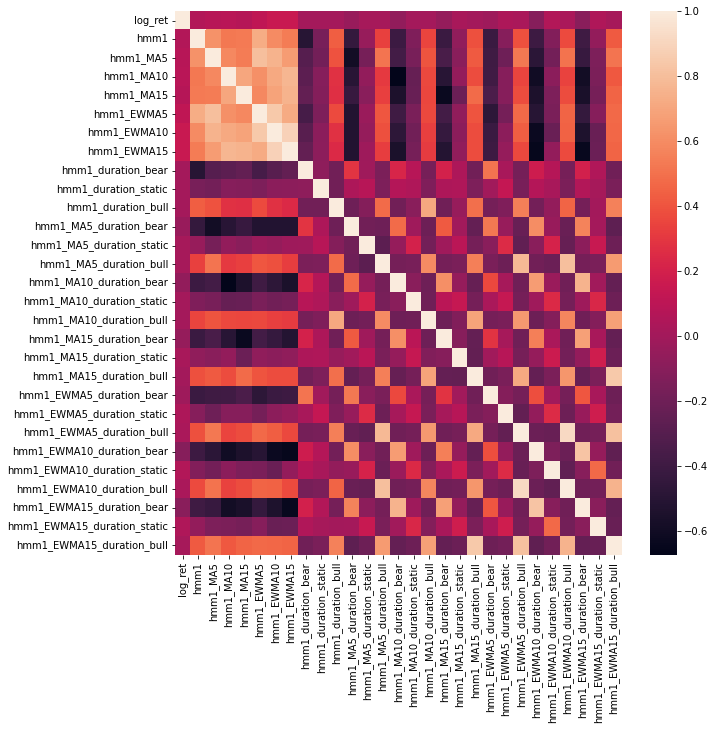

In [18]:
import seaborn as sns
%matplotlib inline

Var_Corr = df_output.corr()

# plot the heatmap and annotation on it
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns)

In [19]:
df_train

,PX_LAST,PX_VOLUME,T1M,T3M,T6M,T1Y,T3Y,T5Y,T10Y,T30Y,T10Y3M,T10Y2Y,LIBOR_3M,TEDRATE,InterestRate,WTI_Futures_Price,WTI_Futures_Return,WTI_Spot_Price,WTI_Spot_Change,Commdity_channel_index_13,Williams_pct_14,RSI_14,Parabolic_0.02_0.2_0.02,DMI_14_ADX,Fear_Greedy_Index,CPI_monthly percent change,CPI_Release,Unemployment_rate,Unemployment_Release,change_in_total_nonfarm_thousand,Nonfarm_Release,VIX_Close,GDP_QOQ_change,GDP_Release,SPY_Adj_Close,SPY_Volume,SP_Adj_Close,SP_Volume,Mkt-RF,SMB,HML,RF,Russell3000_Adj_Close,Russell3000_Volume,log_ret,log_ret_MA5,log_ret_EWMA5,log_ret_MA10,log_ret_EWMA10,log_ret_MA15,log_ret_EWMA15
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,2909.89,1.748611e+09,NaN,5.48,5.55,6.09,6.42,6.50,6.58,6.61,1.10,0.20,6.0000,0.93,5.43,25.60,0.0000,25.60,0.0000,61.0066,-25.0882,64.4827,767.411,23.8369,19.9789,0.2,0.0,4.1,0.0,289.0,0.0,24.209999,5.4,0.0,96.855034,8164300.0,1455.22,9.318000e+08,-0.71,0.62,-1.42,0.021,786.200012,0.0,-0.009003,0.000688,-0.000822,0.002867,0.001006,0.001836,0.001467
2000-01-04,2795.36,1.805332e+09,NaN,5.43,5.50,6.00,6.34,6.40,6.49,6.53,1.06,0.19,6.0400,0.77,5.38,25.55,-0.0020,25.55,-0.0020,-79.2123,-89.3938,42.2468,798.420,23.5873,-2.9796,0.2,0.0,4.1,0.0,289.0,0.0,27.010000,5.4,0.0,93.067421,8089800.0,1399.42,1.009000e+09,-4.06,0.00,2.07,0.021,755.799988,0.0,-0.039434,-0.007637,-0.013693,-0.000997,-0.006347,-0.000677,-0.003646
2000-01-05,2802.51,2.100967e+09,NaN,5.44,5.49,6.05,6.43,6.51,6.62,6.64,1.18,0.24,6.0300,0.75,5.41,24.91,-0.0250,24.91,-0.0250,-141.4229,-74.0882,43.5119,798.420,24.1583,-7.7281,0.2,0.0,4.1,0.0,289.0,0.0,26.410000,5.4,0.0,93.233925,12177900.0,1402.11,1.085500e+09,-0.09,0.20,0.16,0.021,757.090027,0.0,0.001705,-0.008487,-0.008560,-0.002020,-0.004883,0.000168,-0.002977
2000-01-06,2784.07,1.972651e+09,NaN,5.41,5.44,6.03,6.39,6.46,6.57,6.58,1.16,0.22,6.0300,0.78,5.54,24.78,-0.0052,24.78,-0.0052,-120.0770,-83.3148,40.8646,796.196,24.6886,-11.5460,0.2,0.0,4.1,0.0,289.0,0.0,25.730000,5.4,0.0,91.735512,6227200.0,1403.45,1.092300e+09,-0.73,-0.44,1.26,0.021,756.729980,0.0,-0.000476,-0.008653,-0.005865,-0.002353,-0.004082,-0.000207,-0.002664
2000-01-07,2878.11,2.151953e+09,NaN,5.38,5.42,6.00,6.35,6.42,6.52,6.55,1.14,0.21,6.0300,0.81,5.61,24.22,-0.0226,24.22,-0.0226,-39.8800,-37.6259,55.3509,794.061,23.5503,0.1234,0.2,0.0,4.1,0.0,306.0,1.0,21.719999,5.4,0.0,97.063110,8066500.0,1441.47,1.225200e+09,3.21,-0.48,-1.43,0.021,777.250000,0.0,0.026756,-0.004090,0.005008,-0.001072,0.001525,0.001289,0.001013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,8185.44,7.605023e+08,1.15,1.33,1.51,1.73,2.01,2.26,2.48,2.83,1.15,0.57,1.6858,0.38,1.42,58.47,0.0019,58.44,0.0052,78.4624,-14.9463,68.9737,1581.307,30.6732,1.8897,0.3,0.0,4.2,0.0,196.0,0.0,9.900000,2.9,0.0,249.594406,78720900.0,2683.34,2.399830e+09,-0.07,-0.21,-0.21,0.004,1588.250000,0.0,-0.000491,0.000778,0.000665,0.001196,0.001026,0.000946,0.001144
2017-12-26,8179.36,6.517333e+08,1.24,1.47,1.49,1.75,2.02,2.25,2.47,2.82,1.00,0.55,1.6858,0.38,1.42,59.97,0.0236,59.78,0.0229,61.3937,-18.0159,67.6335,1583.911,30.9531,0.5839,0.3,0.0,4.2,0.0,196.0,0.0,10.250000,2.9,0.0,249.295807,45244400.0,2680.50,1.968780e+09,-0.07,0.32,-0.08,0.004,1587.000000,0.0,-0.000787,-0.000624,0.000181,0.000852,0.000696,0.000986,0.000902
2017-12-27,8185.85,6.629423e+08,1.18,1.44,1.50,1.75,1.99,2.22,2.42,2.75,0.98,0.53,1.6934,0.27,1.42,59.64,-0.0055,59.54,-0.0040,61.2921,-15.4011,68.2495,1585.423,31.3726,1.0941,0.3,0.0,4.2,0.0,196.0,0.0,10.470000,2.9,0.0,249.417114,57751000.0,2682.62,2.202080e+09,0.05,-0.13,-0.19,0.004,1588.160034,0.0,0.000731,0.000252,0.000364,0.000837,0.000703,0.001330,0.000881


In [20]:
df_train.isna().sum()

PX_LAST                               0
PX_VOLUME                             0
T1M                                 397
T3M                                   0
T6M                                   0
T1Y                                   0
T3Y                                   0
T5Y                                   0
T10Y                                  0
T30Y                                  0
T10Y3M                                0
T10Y2Y                                0
LIBOR_3M                              0
TEDRATE                               0
InterestRate                          0
WTI_Futures_Price                     0
WTI_Futures_Return                    0
WTI_Spot_Price                        0
WTI_Spot_Change                       0
Commdity_channel_index_13             0
Williams_pct_14                       0
RSI_14                                0
Parabolic_0.02_0.2_0.02               0
DMI_14_ADX                            0
Fear_Greedy_Index                     0


In [21]:
df_train.drop(columns ='T1M').merge(df_output[train_start:train_end],how='outer', left_index=True, right_index=True)

,PX_LAST,PX_VOLUME,T3M,T6M,T1Y,T3Y,T5Y,T10Y,T30Y,T10Y3M,T10Y2Y,LIBOR_3M,TEDRATE,InterestRate,WTI_Futures_Price,WTI_Futures_Return,WTI_Spot_Price,WTI_Spot_Change,Commdity_channel_index_13,Williams_pct_14,RSI_14,Parabolic_0.02_0.2_0.02,DMI_14_ADX,Fear_Greedy_Index,CPI_monthly percent change,CPI_Release,Unemployment_rate,Unemployment_Release,change_in_total_nonfarm_thousand,Nonfarm_Release,VIX_Close,GDP_QOQ_change,GDP_Release,SPY_Adj_Close,SPY_Volume,SP_Adj_Close,SP_Volume,Mkt-RF,SMB,HML,RF,Russell3000_Adj_Close,Russell3000_Volume,log_ret_x,log_ret_MA5,log_ret_EWMA5,log_ret_MA10,log_ret_EWMA10,log_ret_MA15,log_ret_EWMA15,log_ret_y,hmm1,hmm1_MA5,hmm1_MA10,hmm1_MA15,hmm1_EWMA5,hmm1_EWMA10,hmm1_EWMA15,hmm1_duration_bear,hmm1_duration_static,hmm1_duration_bull,hmm1_MA5_duration_bear,hmm1_MA5_duration_static,hmm1_MA5_duration_bull,hmm1_MA10_duration_bear,hmm1_MA10_duration_static,hmm1_MA10_duration_bull,hmm1_MA15_duration_bear,hmm1_MA15_duration_static,hmm1_MA15_duration_bull,hmm1_EWMA5_duration_bear,hmm1_EWMA5_duration_static,hmm1_EWMA5_duration_bull,hmm1_EWMA10_duration_bear,hmm1_EWMA10_duration_static,hmm1_EWMA10_duration_bull,hmm1_EWMA15_duration_bear,hmm1_EWMA15_duration_static,hmm1_EWMA15_duration_bull
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,2909.89,1.748611e+09,5.48,5.55,6.09,6.42,6.50,6.58,6.61,1.10,0.20,6.0000,0.93,5.43,25.60,0.0000,25.60,0.0000,61.0066,-25.0882,64.4827,767.411,23.8369,19.9789,0.2,0.0,4.1,0.0,289.0,0.0,24.209999,5.4,0.0,96.855034,8164300.0,1455.22,9.318000e+08,-0.71,0.62,-1.42,0.021,786.200012,0.0,-0.009003,0.000688,-0.000822,0.002867,0.001006,0.001836,0.001467,-0.009003,1,0,1,1,1,1,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
2000-01-04,2795.36,1.805332e+09,5.43,5.50,6.00,6.34,6.40,6.49,6.53,1.06,0.19,6.0400,0.77,5.38,25.55,-0.0020,25.55,-0.0020,-79.2123,-89.3938,42.2468,798.420,23.5873,-2.9796,0.2,0.0,4.1,0.0,289.0,0.0,27.010000,5.4,0.0,93.067421,8089800.0,1399.42,1.009000e+09,-4.06,0.00,2.07,0.021,755.799988,0.0,-0.039434,-0.007637,-0.013693,-0.000997,-0.006347,-0.000677,-0.003646,-0.039434,-1,-1,1,1,-1,-1,-1,1,0,0,1,0,0,0,0,2,0,0,2,1,0,0,1,0,0,1,0,0
2000-01-05,2802.51,2.100967e+09,5.44,5.49,6.05,6.43,6.51,6.62,6.64,1.18,0.24,6.0300,0.75,5.41,24.91,-0.0250,24.91,-0.0250,-141.4229,-74.0882,43.5119,798.420,24.1583,-7.7281,0.2,0.0,4.1,0.0,289.0,0.0,26.410000,5.4,0.0,93.233925,12177900.0,1402.11,1.085500e+09,-0.09,0.20,0.16,0.021,757.090027,0.0,0.001705,-0.008487,-0.008560,-0.002020,-0.004883,0.000168,-0.002977,0.001705,-1,-1,1,1,-1,-1,-1,2,0,0,2,0,0,0,0,3,0,0,3,2,0,0,2,0,0,2,0,0
2000-01-06,2784.07,1.972651e+09,5.41,5.44,6.03,6.39,6.46,6.57,6.58,1.16,0.22,6.0300,0.78,5.54,24.78,-0.0052,24.78,-0.0052,-120.0770,-83.3148,40.8646,796.196,24.6886,-11.5460,0.2,0.0,4.1,0.0,289.0,0.0,25.730000,5.4,0.0,91.735512,6227200.0,1403.45,1.092300e+09,-0.73,-0.44,1.26,0.021,756.729980,0.0,-0.000476,-0.008653,-0.005865,-0.002353,-0.004082,-0.000207,-0.002664,-0.000476,-1,-1,1,1,-1,-1,-1,3,0,0,3,0,0,0,0,4,0,0,4,3,0,0,3,0,0,3,0,0
2000-01-07,2878.11,2.151953e+09,5.38,5.42,6.00,6.35,6.42,6.52,6.55,1.14,0.21,6.0300,0.81,5.61,24.22,-0.0226,24.22,-0.0226,-39.8800,-37.6259,55.3509,794.061,23.5503,0.1234,0.2,0.0,4.1,0.0,306.0,1.0,21.719999,5.4,0.0,97.063110,8066500.0,1441.47,1.225200e+09,3.21,-0.48,-1.43,0.021,777.250000,0.0,0.026756,-0.004090,0.005008,-0.001072,0.001525,0.001289,0.001013,0.026756,-1,-1,1,1,-1,0,0,4,0,0,4,0,0,0,0,5,0,0,5,4,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,8185.44,7.605023e+08,1.33,1.51,1.73,2.01,2.26,2.48,2.83,1.15,0.57,1.6858,0.38,1.42,58.47,0.0019,58.44,0.0052,78.4624,-14.9463,68.9737,1581.307,30.6732,1.8897,0.3,0.0,4.2,0.0,196.0,0.0,9.900000,2.9,0.0,249.594

In [22]:
# dependent variables used for transition prob.

df_train_tvtp = df_train.drop(columns ='T1M').merge(df_output[train_start:train_end],how='outer', left_index=True, right_index=True)
df_test_tvtp = df_test.drop(columns ='T1M').merge(df_output[train_end:test_end],how='outer', left_index=True, right_index=True)

mean,std = df_train_tvtp.mean(),df_train_tvtp.std()
df_train_tvtp = (df_train_tvtp-df_train_tvtp.mean())/df_train_tvtp.std()
df_train_tvtp['ones'] = 1
df_test_tvtp = (df_test_tvtp-mean)/std
df_test_tvtp['ones'] = 1


In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)

principalComponents = pca.fit_transform(df_train_tvtp)
principalDf_train = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3','principal component 4','principal component 5'])


principalComponents = pca.transform(df_test_tvtp)
principalDf_test = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3','principal component 4','principal component 5'])

In [24]:
pca.explained_variance_ratio_.sum()

0.5548156681284656

In [25]:
duration_static, duration_bear = 2, 4

In [26]:
hmm2 = sm.tsa.MarkovRegression(endog=df_train['log_ret'], k_regimes=2,trend='c', exog_tvtp = principalDf_train,switching_variance=True)
hmm2_results = hmm2.fit(search_reps = 100)
print(hmm2_results.summary())

t1,t2 = Search_train(hmm2_results, duration_static, duration_bear)
label_filtered_result = labeling(hmm2_results,t1,t2)
print((duration(label_filtered_result))[0].mean())
print((duration(label_filtered_result))[1].mean())
print((duration(label_filtered_result))[2].mean())
print((duration(label_filtered_result))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered_result))
print(np.histogram(label_filtered_result))


hmm2_test = sm.tsa.MarkovRegression(endog=df_test['log_ret'], k_regimes=2,trend='c',exog_tvtp = principalDf_test,switching_variance=True)
hmm2_test_results = hmm2_test.fit(start_params = hmm2_results.params, maxiter = 0)

label_filtered_test = labeling(hmm2_test_results,t1,t2)
print((duration(label_filtered_test))[0].mean())
print((duration(label_filtered_test))[1].mean())
print((duration(label_filtered_test))[2].mean())
print((duration(label_filtered_test))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered_test))
print(np.histogram(label_filtered_test))

name3 = 'hmm2'
label_concat = np.concatenate((label_filtered_result,label_filtered_test),axis=None)
df_output[name3] = label_concat

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1782: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (1 - np.diagonal(self.regime_transition).squeeze())


                        Markov Switching Model Results                        
Dep. Variable:                log_ret   No. Observations:                 4534
Model:               MarkovRegression   Log Likelihood               14749.226
Date:                Sun, 13 Feb 2022   AIC                         -29470.453
Time:                        03:41:27   BIC                         -29380.582
Sample:                             0   HQIC                        -29438.798
                               - 4534                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.000     -6.157      0.000      -0.004      -0.002
sigma2         0.0003   1.19e-05     26.972      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0    1.0
dtype: float64
0    14.052632
dtype: float64
0    3.912281
dtype: float64
114
0.47791246821157074 0.9951739427856161
(array([223,   0,   0,   0,   0,   0,   0,   0,   0, 801]), array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ]))


In [27]:
for k in [5,10,15]:

  name = 'log_ret_MA'+str(k)
  
  hmm2 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c', exog_tvtp = principalDf_train,switching_variance=True)
  hmm2_results = hmm2.fit(search_reps = 100)
  print(hmm2_results.summary())

  t1,t2 = Search_train(hmm2_results, duration_static, duration_bear)
  label_filtered_result = labeling(hmm2_results,t1,t2)
  print((duration(label_filtered_result))[0].mean())
  print((duration(label_filtered_result))[1].mean())
  print((duration(label_filtered_result))[2].mean())
  print((duration(label_filtered_result))[3])
  print(df_train['log_ret'].sum(), label_train_logret(label_filtered_result))
  print(np.histogram(label_filtered_result))


  hmm2_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c',exog_tvtp = principalDf_test,switching_variance=True)
  hmm2_test_results = hmm2_test.fit(start_params = hmm2_results.params, maxiter = 0)

  label_filtered_test = labeling(hmm2_test_results,t1,t2)
  print((duration(label_filtered_test))[0].mean())
  print((duration(label_filtered_test))[1].mean())
  print((duration(label_filtered_test))[2].mean())
  print((duration(label_filtered_test))[3])
  print(df_test['log_ret'].sum(), label_test_logret(label_filtered_test))
  print(np.histogram(label_filtered_test))

  name3 = 'hmm2_MA'+str(k)
  label_concat = np.concatenate((label_filtered_result,label_filtered_test),axis=None)
  df_output[name3] = label_concat
  print('===================================================')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1782: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (1 - np.diagonal(self.regime_transition).squeeze())


                        Markov Switching Model Results                        
Dep. Variable:            log_ret_MA5   No. Observations:                 4534
Model:               MarkovRegression   Log Likelihood               18910.151
Date:                Sun, 13 Feb 2022   AIC                         -37792.301
Time:                        03:42:15   BIC                         -37702.430
Sample:                             0   HQIC                        -37760.646
                               - 4534                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016    5.8e-05     26.780      0.000       0.001       0.002
sigma2      6.993e-06   2.43e-07     28.809      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0    12.431373
dtype: float64
0    1.884615
dtype: float64
0    4.692308
dtype: float64
180
0.47791246821157074 2.3776095808408426
(array([244,   0,   0,   0,   0, 147,   0,   0,   0, 633]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1782: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (1 - np.diagonal(self.regime_transition).squeeze())


                        Markov Switching Model Results                        
Dep. Variable:           log_ret_MA10   No. Observations:                 4534
Model:               MarkovRegression   Log Likelihood               20918.053
Date:                Sun, 13 Feb 2022   AIC                         -41808.107
Time:                        03:43:00   BIC                         -41718.236
Sample:                             0   HQIC                        -41776.452
                               - 4534                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015   3.91e-05     37.508      0.000       0.001       0.002
sigma2      2.868e-06   1.05e-07     27.431      0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0    10.411017
dtype: float64
0    2.160494
dtype: float64
0    5.518349
dtype: float64
858
0.6907177051960405 9.896438351709662
(array([1203,    0,    0,    0,    0,  875,    0,    0,    0, 2456]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0    12.702128
dtype: float64
0    2.093023
dtype: float64
0    4.679245
dtype: float64
185
0.47791246821157074 2.511201755052162
(array([248,   0,   0,   0,   0, 180,   0,   0,   0, 596]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1782: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (1 - np.diagonal(self.regime_transition).squeeze())


                        Markov Switching Model Results                        
Dep. Variable:           log_ret_MA15   No. Observations:                 4534
Model:               MarkovRegression   Log Likelihood               22018.247
Date:                Sun, 13 Feb 2022   AIC                         -44008.494
Time:                        03:43:47   BIC                         -43918.623
Sample:                             0   HQIC                        -43976.839
                               - 4534                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018   9.03e-05    -20.182      0.000      -0.002      -0.002
sigma2      1.143e-05   4.25e-07     26.889      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0    4.237037
dtype: float64
0    1.446429
dtype: float64
0    4.565217
dtype: float64
348
0.47791246821157074 2.5702217964074965
(array([210,   0,   0,   0,   0, 243,   0,   0,   0, 571]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


In [28]:
for k in [5,10,15]:

  name = 'log_ret_EWMA'+str(k)
  
  hmm2 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c', exog_tvtp = principalDf_train,switching_variance=True)
  hmm2_results = hmm2.fit(search_reps = 100)
  print(hmm2_results.summary())

  t1,t2 = Search_train(hmm2_results, duration_static, duration_bear)
  label_filtered_result = labeling(hmm2_results,t1,t2)
  print((duration(label_filtered_result))[0].mean())
  print((duration(label_filtered_result))[1].mean())
  print((duration(label_filtered_result))[2].mean())
  print((duration(label_filtered_result))[3])
  print(df_train['log_ret'].sum(), label_train_logret(label_filtered_result))
  print(np.histogram(label_filtered_result))


  hmm2_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c',exog_tvtp = principalDf_test,switching_variance=True)
  hmm2_test_results = hmm2_test.fit(start_params = hmm2_results.params, maxiter = 0)

  label_filtered_test = labeling(hmm2_test_results,t1,t2)
  print((duration(label_filtered_test))[0].mean())
  print((duration(label_filtered_test))[1].mean())
  print((duration(label_filtered_test))[2].mean())
  print((duration(label_filtered_test))[3])
  print(df_test['log_ret'].sum(), label_test_logret(label_filtered_test))
  print(np.histogram(label_filtered_test))

  name3 = 'hmm2_EWMA'+str(k)
  label_concat = np.concatenate((label_filtered_result,label_filtered_test),axis=None)
  df_output[name3] = label_concat

  print('===================================================')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1782: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (1 - np.diagonal(self.regime_transition).squeeze())


                        Markov Switching Model Results                        
Dep. Variable:          log_ret_EWMA5   No. Observations:                 4534
Model:               MarkovRegression   Log Likelihood               19022.302
Date:                Sun, 13 Feb 2022   AIC                         -38016.603
Time:                        03:44:32   BIC                         -37926.732
Sample:                             0   HQIC                        -37984.948
                               - 4534                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019   5.07e-05     37.039      0.000       0.002       0.002
sigma2      5.975e-06    1.8e-07     33.198      0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0    1.0
dtype: float64
0    7.085575
dtype: float64
0    4.009804
dtype: float64
817
0.6907177051960405 7.066846146025503
(array([1636,    0,    0,    0,    0,    0,    0,    0,    0, 2898]), array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ]))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0    1.0
dtype: float64
0    12.935484
dtype: float64
0    3.580645
dtype: float64
124
0.47791246821157074 1.4995593036622221
(array([222,   0,   0,   0,   0,   0,   0,   0,   0, 802]), array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ]))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1782: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (1 - np.diagonal(self.regime_transition).squeeze())


                        Markov Switching Model Results                        
Dep. Variable:         log_ret_EWMA10   No. Observations:                 4534
Model:               MarkovRegression   Log Likelihood               21066.970
Date:                Sun, 13 Feb 2022   AIC                         -42105.941
Time:                        03:45:21   BIC                         -42016.070
Sample:                             0   HQIC                        -42074.286
                               - 4534                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.000    -20.984      0.000      -0.003      -0.002
sigma2      1.902e-05   6.78e-07     28.070      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0    1.0
dtype: float64
0    10.121622
dtype: float64
0    3.716216
dtype: float64
148
0.47791246821157074 1.5878500838657184
(array([275,   0,   0,   0,   0,   0,   0,   0,   0, 749]), array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ]))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1782: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (1 - np.diagonal(self.regime_transition).squeeze())
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: DeprecationWarning: The truth value of an empty array is ambiguous. Returni

                        Markov Switching Model Results                        
Dep. Variable:         log_ret_EWMA15   No. Observations:                 4534
Model:               MarkovRegression   Log Likelihood               22364.164
Date:                Sun, 13 Feb 2022   AIC                         -44700.328
Time:                        03:46:23   BIC                         -44610.457
Sample:                             0   HQIC                        -44668.673
                               - 4534                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016   2.53e-05     65.095      0.000       0.002       0.002
sigma2      1.871e-06   9.39e-08     19.926      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0    1.0
dtype: float64
0    7.727273
dtype: float64
0    3.909091
dtype: float64
176
0.47791246821157074 1.9855300875631992
(array([344,   0,   0,   0,   0,   0,   0,   0,   0, 680]), array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ]))


In [29]:
df_output

,log_ret,hmm1,hmm1_MA5,hmm1_MA10,hmm1_MA15,hmm1_EWMA5,hmm1_EWMA10,hmm1_EWMA15,hmm1_duration_bear,hmm1_duration_static,hmm1_duration_bull,hmm1_MA5_duration_bear,hmm1_MA5_duration_static,hmm1_MA5_duration_bull,hmm1_MA10_duration_bear,hmm1_MA10_duration_static,hmm1_MA10_duration_bull,hmm1_MA15_duration_bear,hmm1_MA15_duration_static,hmm1_MA15_duration_bull,hmm1_EWMA5_duration_bear,hmm1_EWMA5_duration_static,hmm1_EWMA5_duration_bull,hmm1_EWMA10_duration_bear,hmm1_EWMA10_duration_static,hmm1_EWMA10_duration_bull,hmm1_EWMA15_duration_bear,hmm1_EWMA15_duration_static,hmm1_EWMA15_duration_bull,hmm2,hmm2_MA5,hmm2_MA10,hmm2_MA15,hmm2_EWMA5,hmm2_EWMA10,hmm2_EWMA15
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,-0.009003,1,0,1,1,1,1,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,1,1,0,1,0
2000-01-04,-0.039434,-1,-1,1,1,-1,-1,-1,1,0,0,1,0,0,0,0,2,0,0,2,1,0,0,1,0,0,1,0,0,-1,-1,-1,-1,-1,-1,-1
2000-01-05,0.001705,-1,-1,1,1,-1,-1,-1,2,0,0,2,0,0,0,0,3,0,0,3,2,0,0,2,0,0,2,0,0,-1,-1,-1,-1,-1,-1,-1
2000-01-06,-0.000476,-1,-1,1,1,-1,-1,-1,3,0,0,3,0,0,0,0,4,0,0,4,3,0,0,3,0,0,3,0,0,-1,-1,-1,-1,-1,-1,-1
2000-01-07,0.026756,-1,-1,1,1,-1,0,0,4,0,0,4,0,0,0,0,5,0,0,5,4,0,0,0,1,0,0,1,0,-1,0,0,0,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-19,-0.010180,0,-1,-1,-1,-1,-1,-1,0,2,0,2,0,0,4,0,0,2,0,0,2,0,0,4,0,0,3,0,0,-1,-1,-1,-1,-1,-1,-1
2022-01-20,-0.011763,0,-1,-1,-1,-1,-1,-1,0,3,0,3,0,0,5,0,0,3,0,0,3,0,0,5,0,0,4,0,0,-1,-1,-1,-1,-1,-1,-1
2022-01-21,-0.019599,-1,-1,-1,-1,-1,-1,-1,1,0,0,4,0,0,6,0,0,4,0,0,4,0,0,6,0,0,5,0,0,-1,-1,-1,-1,-1,-1,-1


In [30]:
df_output.corr()

,log_ret,hmm1,hmm1_MA5,hmm1_MA10,hmm1_MA15,hmm1_EWMA5,hmm1_EWMA10,hmm1_EWMA15,hmm1_duration_bear,hmm1_duration_static,hmm1_duration_bull,hmm1_MA5_duration_bear,hmm1_MA5_duration_static,hmm1_MA5_duration_bull,hmm1_MA10_duration_bear,hmm1_MA10_duration_static,hmm1_MA10_duration_bull,hmm1_MA15_duration_bear,hmm1_MA15_duration_static,hmm1_MA15_duration_bull,hmm1_EWMA5_duration_bear,hmm1_EWMA5_duration_static,hmm1_EWMA5_duration_bull,hmm1_EWMA10_duration_bear,hmm1_EWMA10_duration_static,hmm1_EWMA10_duration_bull,hmm1_EWMA15_duration_bear,hmm1_EWMA15_duration_static,hmm1_EWMA15_duration_bull,hmm2,hmm2_MA5,hmm2_MA10,hmm2_MA15,hmm2_EWMA5,hmm2_EWMA10,hmm2_EWMA15
log_ret,1.000000,0.060431,0.081479,0.085330,0.077619,0.117462,0.155883,0.154550,0.009897,0.009201,0.010094,-0.036719,0.015748,0.016474,-0.064368,0.011484,0.009149,-0.048219,0.021448,0.003632,-0.012807,0.045587,0.026968,-0.108803,0.064383,0.028203,-0.094852,0.049266,0.016274,0.192987,0.184839,0.202616,0.197472,0.271782,0.282425,0.350720
hmm1,0.060431,1.000000,0.625586,0.527462,0.530378,0.725738,0.598273,0.537454,-0.502796,-0.161909,0.434093,-0.442301,-0.041030,0.338068,-0.406639,-0.132603,0.348050,-0.415960,-0.065908,0.391051,-0.413782,-0.105769,0.387656,-0.404362,-0.120144,0.369354,-0.391810,-0.054572,0.418805,0.640973,0.661912,0.595202,0.559402,0.544438,0.496792,0.348595
hmm1_MA5,0.081479,0.625586,1.000000,0.586428,0.536084,0.808619,0.756131,0.662450,-0.297809,-0.180688,0.394576,-0.593436,-0.166798,0.512545,-0.374222,-0.161363,0.399105,-0.350717,-0.094299,0.423749,-0.392863,-0.197495,0.528497,-0.477505,-0.180445,0.509836,-0.424498,-0.139627,0.514830,0.625828,0.744059,0.727151,0.654141,0.612954,0.612180,0.521916
hmm1_MA10,0.085330,0.527462,0.586428,1.000000,0.701055,0.618463,0.716669,0.767376,-0.269209,-0.109661,0.277129,-0.490760,-0.058638,0.309449,-0.672758,-0.231727,0.360888,-0.490761,-0.058221,0.376728,-0.386387,-0.106828,0.349583,-0.600160,-0.087566,0.343358,-0.590938,-0.144675,0.415510,0.587829,0.669066,0.713636,0.708581,0.569950,0.594835,0.507277
hmm1_MA15,0.077619,0.530378,0.536084,0.701055,1.000000,0.582396,0.688168,0.753634,-0.243990,-0.111241,0.272424,-0.429623,-0.092178,0.332506,-0.543483,-0.226281,0.357224,-0.629400,-0.213243,0.477901,-0.341099,-0.106428,0.375894,-0.546541,-0.140710,0.377164,-0.556661,-0.167509,0.457525,0.590866,0.671067,0.703647,0.797784,0.559705,0.584908,0.531150
hmm1_EWMA5,0.117462,0.725738,0.808619,0.618463,0.582396,1.000000,0.843703,0.724393,-0.359510,-0.138894,0.370194,-0.518210,-0.028547,0.408468,-0.397557,-0.152385,0.360538,-0.376050,-0.065940,0.400685,-0.473830,-0.172618,0.475685,-0.499652,-0.153462,0.453577,-0.442052,-0.106506,0.472929,0.722869,0.830111,0.786341,0.725365,0.714014,0.694100,0.560087
hmm1_EWMA10,0.155883,0.598273,0.756131,0.716669,0.688168,0.843703,1.000000,0.884600,-0.291436,-0.086355,0.279848,-0.519265,-0.050763,0.389257,-0.475136,-0.187563,0.331000,-0.435922,-0.088609,0.378505,-0.413418,-0.079297,0.437537,-0.622366,-0.218658,0.449239,-0.537213,-0.218921,0.465953,0.723002,0.864823,0.874365,0.833581,0.749447,0.772287,0.678550
hmm1_EWMA15,0.154550,0.537454,0.662450,0.767376,0.753634,0.724393,0.884600,1.000000,-0.242920,-0.079429,0.242134,-0.517945,-0.016988,0.322727,-0.551127,-0.168917,0.315990,-0.514416,-0.069376,0.379014,-0.402851,-0.050554,0.366148,-0.647677,-0.056242,0.367350,-0.636348,-0.209365,0.453937,0.671466,0.801808,0.818749,0.840292,0.699879,0.733150,0.658309
hmm1_duration_bear,0.009897,-0.502796,-0.297809,-0.269209,-0.243990,-0.359510,-0.291436,-0.242920,1.000000,-0.076520,-0.188310,0.291798,-0.011323,-0.147977,0.226356,0.083040,-0.164743,0.202835,0.040680,-0.188194,0.514004,0.023672,-0.169756,0.176383,0.075545,-0.164254,0.200058,0.055446,-0.194376,-0.351475,-0.377828,-0.289189,-0.233899,-0.322387,-0.269277,-0.092077
hmm1_duration_static,0.009201,-0.161909,-0.180688,-0.109661,-0.111241,-0.138894,-0.086355,-0.079429,-0.076520,1.000000,-0.187342,0.043887,0.081630,-0.141542,0.065729,0.049176,-0.131967,0.040154,0.048

In [31]:
#df_output.to_csv('gdrive/My Drive/label by hmm1.csv')

In [32]:
df_output

,log_ret,hmm1,hmm1_MA5,hmm1_MA10,hmm1_MA15,hmm1_EWMA5,hmm1_EWMA10,hmm1_EWMA15,hmm1_duration_bear,hmm1_duration_static,hmm1_duration_bull,hmm1_MA5_duration_bear,hmm1_MA5_duration_static,hmm1_MA5_duration_bull,hmm1_MA10_duration_bear,hmm1_MA10_duration_static,hmm1_MA10_duration_bull,hmm1_MA15_duration_bear,hmm1_MA15_duration_static,hmm1_MA15_duration_bull,hmm1_EWMA5_duration_bear,hmm1_EWMA5_duration_static,hmm1_EWMA5_duration_bull,hmm1_EWMA10_duration_bear,hmm1_EWMA10_duration_static,hmm1_EWMA10_duration_bull,hmm1_EWMA15_duration_bear,hmm1_EWMA15_duration_static,hmm1_EWMA15_duration_bull,hmm2,hmm2_MA5,hmm2_MA10,hmm2_MA15,hmm2_EWMA5,hmm2_EWMA10,hmm2_EWMA15
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,-0.009003,1,0,1,1,1,1,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,1,1,0,1,0
2000-01-04,-0.039434,-1,-1,1,1,-1,-1,-1,1,0,0,1,0,0,0,0,2,0,0,2,1,0,0,1,0,0,1,0,0,-1,-1,-1,-1,-1,-1,-1
2000-01-05,0.001705,-1,-1,1,1,-1,-1,-1,2,0,0,2,0,0,0,0,3,0,0,3,2,0,0,2,0,0,2,0,0,-1,-1,-1,-1,-1,-1,-1
2000-01-06,-0.000476,-1,-1,1,1,-1,-1,-1,3,0,0,3,0,0,0,0,4,0,0,4,3,0,0,3,0,0,3,0,0,-1,-1,-1,-1,-1,-1,-1
2000-01-07,0.026756,-1,-1,1,1,-1,0,0,4,0,0,4,0,0,0,0,5,0,0,5,4,0,0,0,1,0,0,1,0,-1,0,0,0,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-19,-0.010180,0,-1,-1,-1,-1,-1,-1,0,2,0,2,0,0,4,0,0,2,0,0,2,0,0,4,0,0,3,0,0,-1,-1,-1,-1,-1,-1,-1
2022-01-20,-0.011763,0,-1,-1,-1,-1,-1,-1,0,3,0,3,0,0,5,0,0,3,0,0,3,0,0,5,0,0,4,0,0,-1,-1,-1,-1,-1,-1,-1
2022-01-21,-0.019599,-1,-1,-1,-1,-1,-1,-1,1,0,0,4,0,0,6,0,0,4,0,0,4,0,0,6,0,0,5,0,0,-1,-1,-1,-1,-1,-1,-1


In [33]:
for model in [	'hmm2',	'hmm2_MA5',	'hmm2_MA10',	'hmm2_MA15',	'hmm2_EWMA5',	'hmm2_EWMA10',	'hmm2_EWMA15']:

  duration_bear = duration_static = duration_bull = 0
  duration_bear_list = []
  duration_static_list = [] 
  duration_bull_list = []

  for i in range(len(df_output[model])):
    if df_output[model].iloc[i] == -1:
      duration_bull = duration_static = 0
      duration_bear+=1 
    elif df_output[model].iloc[i] == 0:
      duration_bull = duration_bear = 0
      duration_static+=1
    else:
      duration_bear = 0
      duration_static = 0
      duration_bull+=1

    duration_bear_list.append(duration_bear)
    duration_static_list.append(duration_static)
    duration_bull_list.append(duration_bull)

  duration_bear_array = np.array(duration_bear_list)
  duration_static_array = np.array(duration_static_list)
  duration_bull_array = np.array(duration_bull_list)

  name1, name2, name3 = model+'_duration_bear', model+'_duration_static', model+'_duration_bull'
  df_output[name1],df_output[name2],df_output[name3] = duration_bear_array,duration_static_array,duration_bull_array

In [38]:
df_output.to_csv('gdrive/My Drive/label by hmm v3.csv')

###HMM1
MA5, MA10, EWMA10


###HMM2
MA5, MA10,


In [35]:
hmm3 = sm.tsa.MarkovRegression(endog=df_train['log_ret'], k_regimes=3,trend='c', exog_tvtp = principalDf_train,switching_variance=True)
hmm3_results = hmm2.fit(search_reps = 100)
print(hmm2_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                        Markov Switching Model Results                        
Dep. Variable:         log_ret_EWMA15   No. Observations:                 4534
Model:               MarkovRegression   Log Likelihood               22364.164
Date:                Sun, 13 Feb 2022   AIC                         -44700.328
Time:                        03:47:12   BIC                         -44610.457
Sample:                             0   HQIC                        -44668.673
                               - 4534                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016   2.53e-05     65.095      0.000       0.002       0.002
sigma2      1.871e-06   9.39e-08     19.926      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1782: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (1 - np.diagonal(self.regime_transition).squeeze())


In [36]:
hmm4 = sm.tsa.MarkovRegression(endog=df_train['log_ret'], k_regimes=4,trend='c', exog_tvtp = principalDf_train,switching_variance=True)
hmm4_results = hmm2.fit(search_reps = 100)
print(hmm2_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                        Markov Switching Model Results                        
Dep. Variable:         log_ret_EWMA15   No. Observations:                 4534
Model:               MarkovRegression   Log Likelihood               22364.164
Date:                Sun, 13 Feb 2022   AIC                         -44700.328
Time:                        03:47:34   BIC                         -44610.457
Sample:                             0   HQIC                        -44668.673
                               - 4534                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016   2.53e-05     65.095      0.000       0.002       0.002
sigma2      1.871e-06   9.39e-08     19.926      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1782: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (1 - np.diagonal(self.regime_transition).squeeze())


In [37]:
hmm5 = sm.tsa.MarkovRegression(endog=df_train['log_ret'], k_regimes=5,trend='c', exog_tvtp = principalDf_train,switching_variance=True)
hmm5_results = hmm2.fit(search_reps = 100)
print(hmm2_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                        Markov Switching Model Results                        
Dep. Variable:         log_ret_EWMA15   No. Observations:                 4534
Model:               MarkovRegression   Log Likelihood               22364.164
Date:                Sun, 13 Feb 2022   AIC                         -44700.328
Time:                        03:48:05   BIC                         -44610.457
Sample:                             0   HQIC                        -44668.673
                               - 4534                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016   2.53e-05     65.095      0.000       0.002       0.002
sigma2      1.871e-06   9.39e-08     19.926      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1782: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (1 - np.diagonal(self.regime_transition).squeeze())
